In [9]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import os

# Load dataset
root = '../data/'
path = 'ml_features_subset.csv'
df = pd.read_csv(os.path.join(root,path))

# Convert time column to datetime if needed and sort by date
df["date"] = pd.to_datetime(df["date"])
df = df[['spike_30', 'past_spikes_30', 'wind_speed', 'precipitation', 'hdd', 'cdd', 'past_da_load_error', 'past_da_price_error', 'month', 'hour', 'is_weekend', 'is_holiday',
         'load_capacity_ratio' ]]

target_col = "spike_30"  # Replace with your target column name

# Drop rows with NaN values resulting from lag feature creation
df.dropna(inplace=True)

# Define feature set by excluding the date and target columns
features = [col for col in df.columns if col not in ["date", target_col]]
X = df[features]
y = df[target_col]

# Split into train and test sets without shuffling (to maintain time order)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Train the Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Output feature importances
feature_importances = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf_model.feature_importances_
}).sort_values(by='importance', ascending=False)
print("Feature Importances:")
print(feature_importances)

# Make predictions on the test set
y_pred = rf_model.predict(X_test)

# Evaluate model performance using Mean Squared Error
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse:.4f}")



Feature Importances:
                feature  importance
6   past_da_price_error    0.164633
5    past_da_load_error    0.153175
11  load_capacity_ratio    0.151313
1            wind_speed    0.140103
3                   hdd    0.101046
8                  hour    0.090498
0        past_spikes_30    0.085316
4                   cdd    0.046454
7                 month    0.039976
2         precipitation    0.014673
9            is_weekend    0.012802
10           is_holiday    0.000011
Mean Squared Error: 0.0879


In [10]:
correlation_with_target = df.corr()[target_col].sort_values(ascending=False)

# Display the correlation table
print("Correlation of all features with the target:")
print(correlation_with_target)

Correlation of all features with the target:
spike_30               1.000000
past_spikes_30         0.265589
past_da_price_error    0.095577
cdd                    0.089327
hour                   0.088691
wind_speed             0.053426
month                  0.044466
past_da_load_error     0.017480
hdd                    0.007852
load_capacity_ratio   -0.001392
precipitation         -0.003551
is_holiday            -0.009463
is_weekend            -0.012176
Name: spike_30, dtype: float64


Feature Importances:
                feature  importance
6   past_da_price_error    0.164506
11  load_capacity_ratio    0.142958
5    past_da_load_error    0.142136
1            wind_speed    0.134892
0        past_spikes_30    0.095420
8                  hour    0.094088
3                   hdd    0.088652
4                   cdd    0.058840
7                 month    0.049611
9            is_weekend    0.016488
2         precipitation    0.012378
10           is_holiday    0.000031
Random Forest AUC: 0.8028


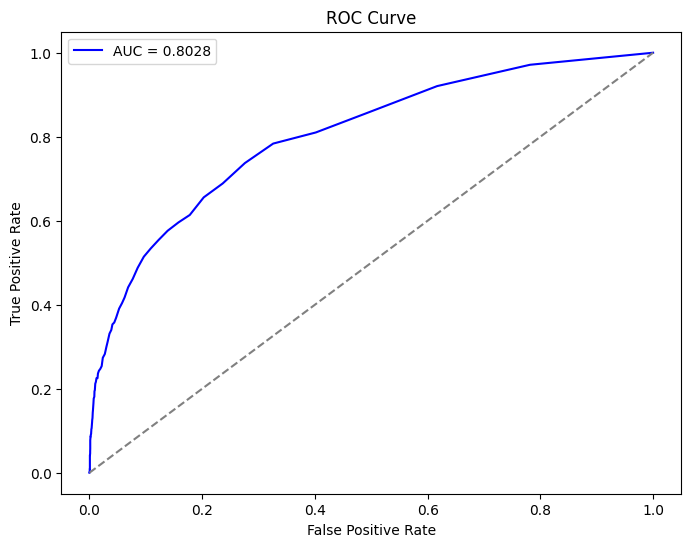

In [11]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

df = pd.read_csv(os.path.join(root,path))
df = df[['spike_30', 'past_spikes_30', 'wind_speed', 'precipitation', 'hdd', 'cdd', 'past_da_load_error', 'past_da_price_error', 'month', 'hour', 'is_weekend', 'is_holiday',
         'load_capacity_ratio' ]]

# Split data into train and test sets
X = df[features]
y = df[target_col]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Get predicted probabilities for the positive class (1)
y_probs = rf_model.predict_proba(X_test)[:, 1]

feature_importances = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf_model.feature_importances_
}).sort_values(by='importance', ascending=False)
print("Feature Importances:")
print(feature_importances)

# Compute AUC
auc = roc_auc_score(y_test, y_probs)
print(f"Random Forest AUC: {auc:.4f}")

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_probs)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}", color="blue")
plt.plot([0, 1], [0, 1], linestyle="--", color="grey")  # Random classifier line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()
